In [235]:
from utils.processing import Processing
import mne
import numpy as np

In [236]:
data_path = mne.datasets.ssvep.data_path()
bids_fname = (
    data_path / "sub-02" / "ses-01" / "eeg" / "sub-02_ses-01_task-ssvep_eeg.vhdr"
)

raw = mne.io.read_raw_brainvision(bids_fname, preload=True, verbose=False)

# Set montage
montage = mne.channels.make_standard_montage("easycap-M1")
raw.set_montage(montage, verbose=False)

# Set common average reference
raw.set_eeg_reference("average", projection=False, verbose=False)
raw.pick(["O1", "O2", "Fp1", "Fp2"])
raw.crop(tmax=10)

Measurement date,"September 27, 2018 14:48:36 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,4 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.02 Hz
Lowpass,1000.00 Hz


In [237]:
# raw = mne.io.read_raw("subj-1_ses-S001_task-blink-mini_run-001_20240519_165819_eeg_8a04682c-c848-4605-95e8-fea8ba1897d4-raw.fif", preload=True).pick("eeg")

In [238]:
raw.ch_names

['O1', 'O2', 'Fp1', 'Fp2']

In [239]:
# raw.plot()
raw.filter(1, 40, fir_design="firwin")
raw.resample(256)

Measurement date,"September 27, 2018 14:48:36 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,4 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [240]:
raw.plot()

In [241]:
from mne.preprocessing import ICA

In [242]:
reconstructed = raw.copy()

ica = ICA(
    n_components=len(raw.ch_names),
    max_iter="auto",
    method="picard",
    random_state=97,
).fit(reconstructed)

In [243]:
# ica.plot_components();

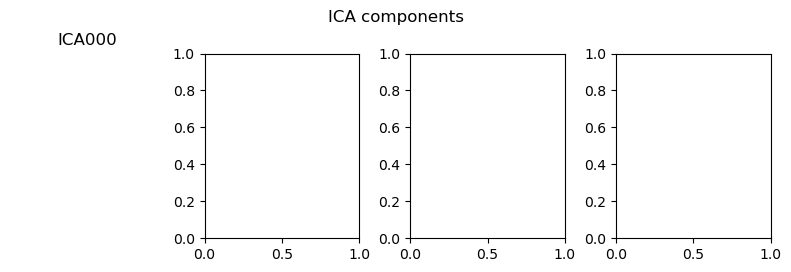

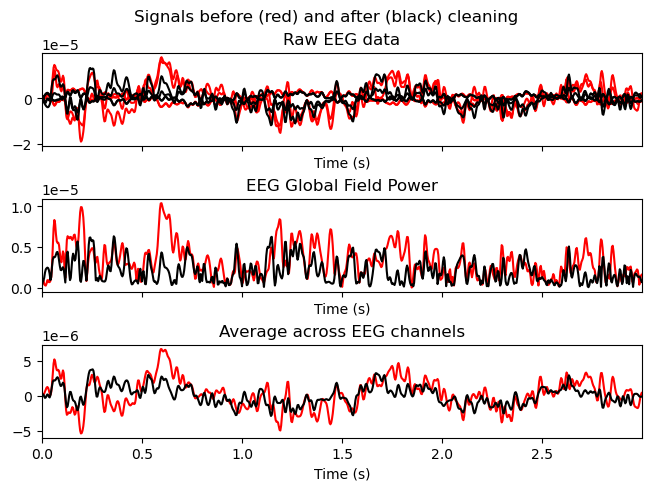

In [244]:
ica.plot_overlay(raw, exclude=[0], picks="eeg");

In [245]:
# ica.plot_properties(raw, picks=[0])

In [246]:
eog_indices, eog_scores = ica.find_bads_eog(
    reconstructed, ch_name=["Fp1", "Fp2"]
)
ica.exclude = eog_indices

In [247]:
eog_indices

[]

In [248]:
ica.plot_sources(raw, show_scrollbars=False);

In [249]:
# # barplot of ICA component "EOG match" scores
# ica.plot_scores(eog_scores)

# # # plot diagnostics
# ica.plot_properties(self.raw, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
# ica.plot_sources(self.raw, show_scrollbars=False)

ica.apply(reconstructed)

reconstructed.plot()

In [250]:
# clean = Processing(raw=raw, mode="ICA")